In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
sns.set()

### Using average tone across Daily Mail articles which have more than 10% of economic themes 

In [2]:
client = bigquery.Client()

threshold = 0.1

query=f"""
SELECT b.DATE, TONE, POSITIVE_SCORE, NEGATIVE_SCORE, POLARITY, GDP from
(SELECT 
DATE_TRUNC(DATE , MONTH) DATE
,AVG(TONE) TONE
,AVG(POSITIVE_SCORE) POSITIVE_SCORE
,AVG(NEGATIVE_SCORE) NEGATIVE_SCORE
,AVG(POLARITY) POLARITY
FROM goldenfleece.final_task.gkg_daily_mail
where Econ_Theme_Prop > {threshold}
group by DATE) a
right join goldenfleece.final_task.monthly_gdp_lag b
on a.DATE = b.DATE
where b.DATE >= '2015-02-01'
order by b.DATE
"""
gdp_df = client.query(query).to_dataframe()
gdp_df.head()

,DATE,TONE,POSITIVE_SCORE,NEGATIVE_SCORE,POLARITY,GDP
0,2015-02-01,None,None,None,None,0.4
1,2015-03-01,-0.694302924,2.658678497,3.352981421,6.011659919,0.4
2,2015-04-01,-0.551040943,2.531539929,3.082580871,5.614120800,0.6
3,2015-05-01,-0.718312348,2.435169584,3.153481932,5.588651516,0.7
4,2015-06-01,-0.791295954,2.381608524,3.172904478,5.554513002,0.7


In [3]:
gdp_df = gdp_df.astype({"DATE":"datetime64", "TONE":float, "POSITIVE_SCORE":float, "NEGATIVE_SCORE":float, "POLARITY":float}) 
gdp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DATE            68 non-null     datetime64[ns]
 1   TONE            67 non-null     float64       
 2   POSITIVE_SCORE  67 non-null     float64       
 3   NEGATIVE_SCORE  67 non-null     float64       
 4   POLARITY        67 non-null     float64       
 5   GDP             68 non-null     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 3.3 KB


<AxesSubplot:xlabel='DATE'>

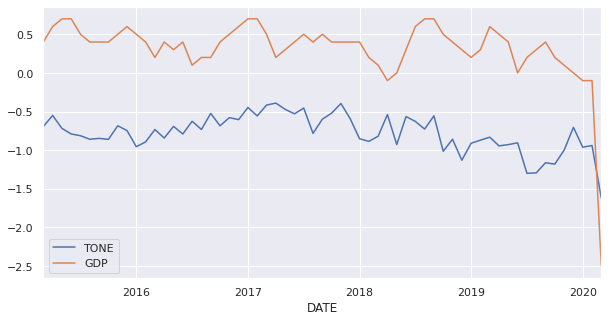

In [4]:
gdp_df[["TONE", "GDP", "DATE"]].set_index("DATE").loc["2015-03-01":"2020-03-01"].plot(figsize=(10,5))

In [5]:
from cross_validate import cross_validate, build_design_matrix, evaluate_features

### Check stationarity assumption

From visual inspection, exclude COVID period to satisfy stationarity assumption

#todo Apply smoothing to TONE 

In [6]:
from sklearn.linear_model import LinearRegression

lr=LinearRegression()

rmse_list = []
design_df_list = []
result_df_list = []
for horizon in [1,2,3,4,5,6]:
    design_df, result_df = evaluate_features(
        gdp_df,
        date_col="DATE",
        var_col="GDP",
        horizon=horizon,
        estimator=lr,
        window=36,
        period=1,
        return_model=True,
        start_date="2015-03-01",
        end_date="2020-03-01",
    )
    rmse = (((result_df["pred"] - result_df["actual"]) ** 2).mean()) ** 0.5
    rmse_list.append(rmse)
    design_df_list.append(design_df)
    result_df_list.append(result_df)
    print(f"Average RMSE over {len(result_df)} predictions for {horizon}-month horizon: {rmse:.3f}")

print(f"\nAverage RMSE across different horizons: {np.array(rmse_list).mean():.3f}")

Average RMSE over 22 predictions for 1-month horizon: 0.631
Average RMSE over 20 predictions for 2-month horizon: 0.708
Average RMSE over 18 predictions for 3-month horizon: 0.763
Average RMSE over 16 predictions for 4-month horizon: 0.761
Average RMSE over 14 predictions for 5-month horizon: 0.811
Average RMSE over 12 predictions for 6-month horizon: 0.901

Average RMSE across different horizons: 0.763


<AxesSubplot:xlabel='date'>

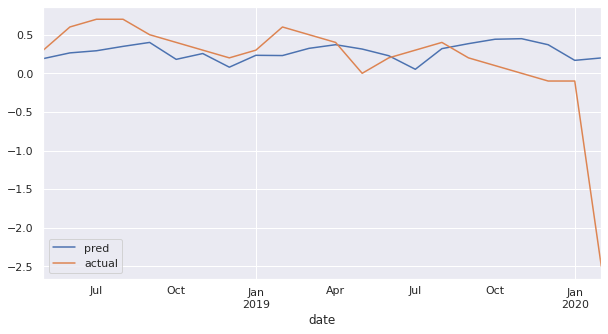

In [7]:
# check 1-month horizon plot
result_df = result_df_list[0]
result_df[["pred", "actual", "date"]].set_index("date").plot(figsize=(10,5))